<a href="https://colab.research.google.com/github/juan-castro-net/artificial_intelligence/blob/main/examples/vision/ipynb/image_classification_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification from scratch

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/04/27<br>
**Last modified:** 2023/11/09<br>
**Description:** Training an image classifier from scratch on the Kaggle Cats vs Dogs dataset.

## Introduction

This example shows how to do image classification from scratch, starting from JPEG
image files on disk, without leveraging pre-trained weights or a pre-made Keras
Application model. We demonstrate the workflow on the Kaggle Cats vs Dogs binary
classification dataset.

We use the `image_dataset_from_directory` utility to generate the datasets, and
we use Keras image preprocessing layers for image standardization and data augmentation.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Setup

In [1]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

## Load the data: the Cats vs Dogs dataset

### Raw data download

First, let's download the 786M ZIP archive of the raw data:

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   262M      0  0:00:02  0:00:02 --:--:--  262M


In [3]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf   kagglecatsanddogs_5340.zip   PetImages  'readme[1].txt'   sample_data


Now we have a `PetImages` folder which contain two subfolders, `Cat` and `Dog`. Each
subfolder contains image files for each category.

In [4]:
!ls PetImages

Cat  Dog


### Filter out corrupted images

When working with lots of real-world image data, corrupted images are a common
occurence. Let's filter out badly-encoded images that do not feature the string "JFIF"
in their header.

In [5]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.


## Generate a `Dataset`

In [14]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    label_mode="categorical",
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


## Visualize the data

Here are the first 9 images in the training dataset.

tf.Tensor([1. 0.], shape=(2,), dtype=float32)
tf.Tensor([1. 0.], shape=(2,), dtype=float32)
tf.Tensor([0. 1.], shape=(2,), dtype=float32)
tf.Tensor([1. 0.], shape=(2,), dtype=float32)
tf.Tensor([1. 0.], shape=(2,), dtype=float32)
tf.Tensor([1. 0.], shape=(2,), dtype=float32)
tf.Tensor([0. 1.], shape=(2,), dtype=float32)
tf.Tensor([0. 1.], shape=(2,), dtype=float32)
tf.Tensor([0. 1.], shape=(2,), dtype=float32)


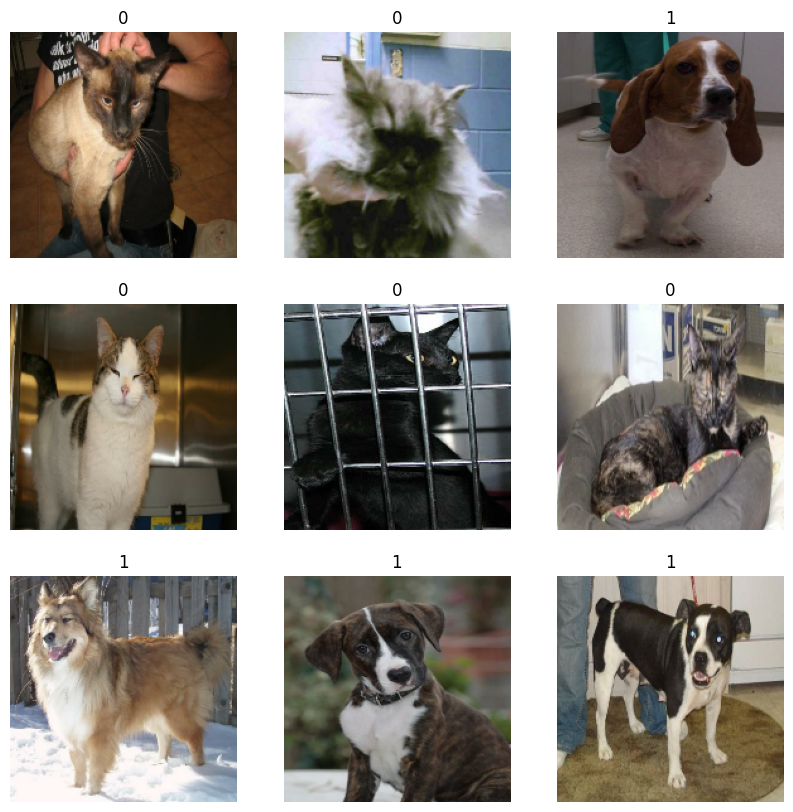

In [16]:

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(np.argmax(labels[i]))
        print(labels[i])
        plt.axis("off")

## Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to the
training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
overfitting.

In [8]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images


Let's visualize what the augmented samples look like, by applying `data_augmentation`
repeatedly to the first few images in the dataset:

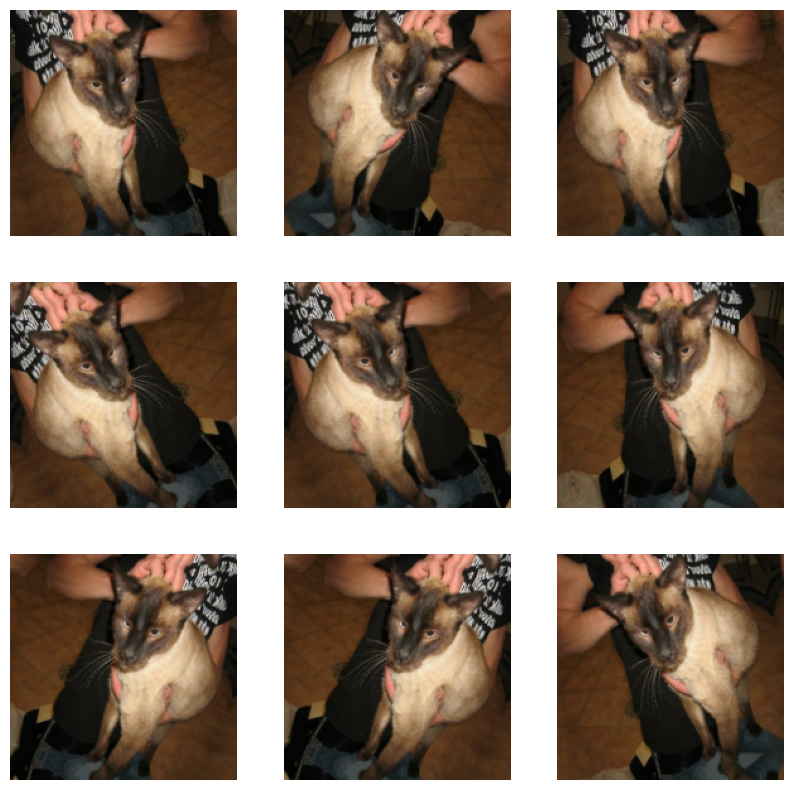

In [9]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")


## Standardizing the data

Our image are already in a standard size (180x180), as they are being yielded as
contiguous `float32` batches by our dataset. However, their RGB channel values are in
the `[0, 255]` range. This is not ideal for a neural network;
in general you should seek to make your input values small. Here, we will
standardize values to be in the `[0, 1]` by using a `Rescaling` layer at the start of
our model.

## Two options to preprocess the data

There are two ways you could be using the `data_augmentation` preprocessor:

**Option 1: Make it part of the model**, like this:

```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
...  # Rest of the model
```

With this option, your data augmentation will happen *on device*, synchronously
with the rest of the model execution, meaning that it will benefit from GPU
acceleration.

Note that data augmentation is inactive at test time, so the input samples will only be
augmented during `fit()`, not when calling `evaluate()` or `predict()`.

If you're training on GPU, this may be a good option.

**Option 2: apply it to the dataset**, so as to obtain a dataset that yields batches of
augmented images, like this:

```python
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))
```

With this option, your data augmentation will happen **on CPU**, asynchronously, and will
be buffered before going into the model.

If you're training on CPU, this is the better option, since it makes data augmentation
asynchronous and non-blocking.

In our case, we'll go with the second option. If you're not sure
which one to pick, this second option (asynchronous preprocessing) is always a solid choice.

## Configure the dataset for performance

Let's apply data augmentation to our training dataset,
and let's make sure to use buffered prefetching so we can yield data from disk without
having I/O becoming blocking:

In [17]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

## Build a model

We'll build a small version of the Xception network. We haven't particularly tried to
optimize the architecture; if you want to do a systematic search for the best model
configuration, consider using
[KerasTuner](https://github.com/keras-team/keras-tuner).

Note that:

- We start the model with the `data_augmentation` preprocessor, followed by a
 `Rescaling` layer.
- We include a `Dropout` layer before the final classification layer.

In [30]:
model = keras.applications.DenseNet121(
    include_top=True,
    weights=None, #"imagenet",
    input_shape=image_size + (3,),
    classes=2,
    classifier_activation="softmax",
    name="densenet121",
)

## Train the model

In [32]:
epochs = 5

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    #loss=keras.losses.BinaryCrossentropy(from_logits=True),
    loss="categorical_crossentropy", #keras.losses.CategoricalCrossentropy(), #from_logits=True),
    #metrics=[keras.metrics.BinaryAccuracy(name="acc")],
    metrics=["accuracy"],
)


In [33]:
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 443s 2s/step - accuracy: 0.6466 - loss: 0.6721 - val_accuracy: 0.5884 - val_loss: 0.7470
Epoch 2/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 140s 948ms/step - accuracy: 0.7527 - loss: 0.4962 - val_accuracy: 0.5455 - val_loss: 0.9579
Epoch 3/5
 52/147 ━━━━━━━━━━━━━━━━━━━━ 1:16 805ms/step - accuracy: 0.8160 - loss: 0.4011

KeyboardInterrupt: 

In [34]:
model = keras.models.load_model("/content/save_at_2.keras")

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
    initial_epoch=2
)

Epoch 3/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 319s 1s/step - accuracy: 0.8230 - loss: 0.3910 - val_accuracy: 0.6027 - val_loss: 0.7376
Epoch 4/5


KeyboardInterrupt: 

In [36]:
model2 = keras.applications.ResNet50V2(
    include_top=True,
    weights=None,
    input_shape=image_size + (3,),
    classes=2,
    classifier_activation="softmax",
    name="densenet121",
)

epochs = 5

callbacks = [
    keras.callbacks.ModelCheckpoint("model_2_at_{epoch}.keras"),
]
model2.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    #loss=keras.losses.BinaryCrossentropy(from_logits=True),
    loss="categorical_crossentropy", #keras.losses.CategoricalCrossentropy(), #from_logits=True),
    #metrics=[keras.metrics.BinaryAccuracy(name="acc")],
    metrics=["accuracy"],
)

history = model2.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
    initial_epoch=0
)


Epoch 1/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 243s 1s/step - accuracy: 0.6222 - loss: 0.7329 - val_accuracy: 0.5325 - val_loss: 0.9495
Epoch 2/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 176s 873ms/step - accuracy: 0.7019 - loss: 0.5695 - val_accuracy: 0.7138 - val_loss: 0.5817
Epoch 3/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 146s 906ms/step - accuracy: 0.7502 - loss: 0.5032 - val_accuracy: 0.7497 - val_loss: 0.5258
Epoch 4/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 145s 926ms/step - accuracy: 0.7868 - loss: 0.4510 - val_accuracy: 0.6988 - val_loss: 0.5836
Epoch 5/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.8148 - loss: 0.4057 - val_accuracy: 0.7219 - val_loss: 0.5555


In [67]:
import base64

image_path = "/content/cat3.jpeg"
with open(image_path, "rb") as imageFile:
    #print(type(imageFile.read()))
    img_base64 = base64.b64encode(imageFile.read())
    print(img_base64)


b'/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxITEhUSExMVFhUVFxgYGBgXFxgaGBUXFxgYGhgYGBoZHSgiGBolGxgXITEhJSkrLi4uGB8zODMtNygtLisBCgoKDg0OGhAQFy0dHyUtLS0tLS0tLS0tLS0tLS4tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLf/AABEIAOEA4QMBIgACEQEDEQH/xAAcAAEAAQUBAQAAAAAAAAAAAAAABAIDBQYHAQj/xABAEAABAwIDBQUHAwIEBQUAAAABAAIRAyEEEjEFQVFhcQYigZGhBxMyscHR8EJSciPhFIKy8RUzYnOSJIOiwtL/xAAZAQEAAwEBAAAAAAAAAAAAAAAAAQIDBAX/xAAgEQEBAQEAAwEAAgMAAAAAAAAAAQIRAyExEjJBBCJh/9oADAMBAAIRAxEAPwDhqIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIilbMwFSvVbSptLnvMAfU8kt4SdRUW89uewn+Bw1KqH5yX5HwNCWkjqO6VoyiWWdidZsvKIiKUCIiAiIgIiICIiAiIgIiICIiAikbPwbqtRtNgJc4wAFvNX2ed0f1Rmjc2RPA3uqa3nP1fOLr458izG3OzdfC3e2WfvbcX0ngsOrTUs7FbLLyiIilAiIgIiIC7b7HeywpUji6g79Qd2f0s18zquWdlNinFYhlOO7IzdBqvpVlIUqTWMgACFju9v5bePPJ1p/tRIds7E8vdkdRWpjzgkeK4Au9e0UkbOxEgmfdi1p/qMPPguCq+FfJ9ERFdmIiICIiAiIgIiICIiAiIgIiIN/wDZdgRFevvblpt5ZpLvQALfaAuB9Fp/stP/AKat/wB1n+krcMOzvydFzb/lXXif6xLxODa5pBGYHUESCDqI3ghce7adnP8ADv8AeUx/ReY/7b97Dy

In [73]:
import base64
from PIL import Image

image_path = "/content/cat3.jpeg"

pil_image = Image.open(image_path)
image_array = np.array(pil_image,dtype=np.float32)

def numpy_to_base64(image_array):
    # Convert NumPy array to PIL image
    pil_image = Image.fromarray(np.uint8(image_array))

    # Save the image to a bytes buffer in JPEG format
    buffer = io.BytesIO()
    pil_image.save(buffer, format="JPEG")

    # Encode the buffered image to base64 string
    base64_image = base64.b64encode(buffer.getvalue()).decode("utf-8")

    return base64_image

base64_string = numpy_to_base64(image_array)
print(base64_string)

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCADhAOEDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD5/ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACilNXdM0261bUIbK0iaW4mbaq/wBT7UN2GlcpUV6D43+H

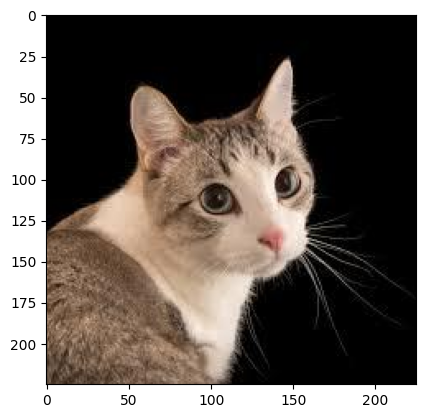

In [74]:
from PIL import Image
import base64
import io
import numpy as np

base64_decoded = base64.b64decode(base64_string)

image = Image.open(io.BytesIO(base64_decoded))
image_np = np.array(image)

plt.imshow(image_np)
plt.show()

We get to >90% validation accuracy after training for 25 epochs on the full dataset
(in practice, you can train for 50+ epochs before validation performance starts degrading).

## Run inference on new data

Note that data augmentation and dropout are inactive at inference time.

In [ ]:
img = keras.utils.load_img("PetImages/Cat/6779.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")